# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import datetime
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix, roc_curve
from tensorflow.keras.metrics import AUC
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
%load_ext tensorboard
import keras_tuner as kt
from keras_tuner import HyperParameters, Tuner
from keras_tuner import Objective
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_recall_curve, average_precision_score
from tensorflow.keras.applications.densenet import DenseNet121
import time

In [2]:
# Define the MirroredStrategy
mirrored_strategy = tf.distribute.MirroredStrategy()
num_gpus = mirrored_strategy.num_replicas_in_sync
num_gpus

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


4

In [3]:
approach = "umulti_ht_noaug"

source_path = '.'
# all_pathology = ['Atelectasis','Cardiomegaly','Consolidation','Edema','Pleural Effusion']
all_pathology = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion',
                   'No Finding', 'Enlarged Cardiomediastinum', 'Lung Opacity', 'Lung Lesion', 
                   'Pneumonia', 'Pneumothorax', 'Pleural Other', 'Fracture', 'Support Devices']

competition_pathology = ['Atelectasis','Cardiomegaly','Consolidation','Edema','Pleural Effusion']

local_batch = 16
batch_size = local_batch*num_gpus
AUTOTUNE = tf.data.AUTOTUNE
augmentation_setting = False

iterations = 4800
checkpoint_start = int(iterations/num_gpus)
top_rank = 20

# Loading Dataset

In [4]:
source_path = '.'
train_directory = os.path.join(source_path, 'CheXpert-v1.0/train')
validation_directory = os.path.join(source_path, 'CheXpert-v1.0/valid')
test_directory = os.path.join(source_path, 'CheXpert-v1.0/test')

print(f"There are {len(os.listdir(train_directory))}")
print(f"There are {len(os.listdir(validation_directory))}")
print(f"There are {len(os.listdir(test_directory))}")

There are 64540
There are 200
There are 500


In [5]:
# Load train and valid labels
train_df = pd.read_csv(os.path.join(source_path, 'CheXpert-v1.0/train.csv'))
valid_df = pd.read_csv(os.path.join(source_path, 'CheXpert-v1.0/valid.csv'))
test_df = pd.read_csv(os.path.join(source_path, 'CheXpert-v1.0/test.csv'))

# Load training and validation image paths
train_image_paths = [source_path + '/' + path for path in train_df['Path']]
valid_image_paths = [source_path + '/' + path for path in valid_df['Path']]
test_image_paths = [source_path + '/' + path for path in test_df['Path']]

# Create TensorFlow tensors from image paths
train_image_paths = tf.constant(train_image_paths)
valid_image_paths = tf.constant(valid_image_paths)
test_image_paths = tf.constant(test_image_paths)

# Creating DataFrames

In [6]:
train_df = train_df[all_pathology]
# print(train_df.head())     # printing first five rows of the file
# print(train_df.columns)

In [7]:
valid_df = valid_df[all_pathology]
# print(valid_df.head())     # printing first five rows of the file
# print(valid_df.columns)

In [8]:
test_df = test_df[all_pathology]

# Train and Valid Labels

In [9]:
train_df_UMultiClass = train_df.replace(-1,2).fillna(0)
# print(len(train_df_UMultiClass))
train_labels = np.array(train_df_UMultiClass)
# print(train_labels)

In [10]:
# #Transforming Training Labels to 15 classes

# trans_train_labels = np.zeros((train_labels.shape[0], len(all_pathology)*3))
# for i in range(train_labels.shape[0]):
#     for j in range (0,len(all_pathology)):
#         index = int(j * 3 + train_labels[i,j])
#         trans_train_labels[i,index] = 1
        
# print(trans_train_labels[0])

# # Separating the labels for 5 Pathologies
# for k in range(1, len(all_pathology)+1):  # Assuming there are 5 pathologies
#     start_index = (k - 1) * 3
#     end_index = start_index + 3
#     globals()[f'train_Pathology{k}_labels'] = trans_train_labels[:, start_index:end_index].astype('float32')
#     print(globals()[f'train_Pathology{k}_labels'][0])

In [11]:
# Your existing code for trans_train_labels
trans_train_labels = np.zeros((train_labels.shape[0], len(all_pathology)*3))
for i in range(train_labels.shape[0]):
    for j in range (0,len(all_pathology)):
        index = int(j * 3 + train_labels[i,j])
        trans_train_labels[i,index] = 1

print(trans_train_labels[0])

# Create a list to store pathology label arrays
train_labels_list = []

for k in range(1, len(all_pathology)+1):
    start_index = (k - 1) * 3
    end_index = start_index + 3
    train_label_trunc = trans_train_labels[:, start_index:end_index].astype('float32')
    globals()[f'train_Pathology{k}_labels'] = train_label_trunc
    train_labels_list.append(train_label_trunc)
    print(globals()[f'train_Pathology{k}_labels'][0])

[1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]


In [12]:
valid_df_UMultiClass = valid_df.replace(-1,2).fillna(0)
print(len(valid_df_UMultiClass))
valid_labels = np.array(valid_df_UMultiClass)
print(valid_labels)

234
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 1. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [13]:
# #Transforming Validation Labels to 15 classes

# trans_valid_labels = np.zeros((valid_labels.shape[0], len(all_pathology)*3))
# for i in range(valid_labels.shape[0]):
#     for j in range (0,len(all_pathology)):
#         index = int(j * 3 + valid_labels[i,j])
#         trans_valid_labels[i,index] = 1
        
# print(trans_valid_labels[0])

# # Separating the labels for 5 Pathologies
# for k in range(1, len(all_pathology)+1):  # Assuming there are 5 pathologies
#     start_index = (k - 1) * 3
#     end_index = start_index + 3
#     globals()[f'valid_Pathology{k}_labels'] = trans_valid_labels[:, start_index:end_index].astype('float32')
#     print(globals()[f'valid_Pathology{k}_labels'][0])

In [14]:
# Your existing code for trans_train_labels
trans_valid_labels = np.zeros((valid_labels.shape[0], len(all_pathology)*3))
for i in range(valid_labels.shape[0]):
    for j in range (0,len(all_pathology)):
        index = int(j * 3 + valid_labels[i,j])
        trans_valid_labels[i,index] = 1

print(trans_valid_labels[0])

# Create a list to store pathology label arrays
valid_labels_list = []

for k in range(1, len(all_pathology)+1):
    start_index = (k - 1) * 3
    end_index = start_index + 3
    valid_label_trunc = trans_valid_labels[:, start_index:end_index].astype('float32')
    globals()[f'valid_Pathology{k}_labels'] = valid_label_trunc
    valid_labels_list.append(valid_label_trunc)
    print(globals()[f'valid_Pathology{k}_labels'][0])

[1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]


In [15]:
test_df_UMultiClass = test_df.replace(-1,2).fillna(0)
print(len(test_df_UMultiClass))
test_labels = np.array(test_df_UMultiClass)
print(test_labels)

668
[[0. 1. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [1. 1. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 1.]]


In [16]:
# #Transforming Validation Labels to 15 classes

# trans_test_labels = np.zeros((test_labels.shape[0], len(all_pathology)*3))
# for i in range(test_labels.shape[0]):
#     for j in range (0,len(all_pathology)):
#         index = int(j * 3 + test_labels[i,j])
#         trans_test_labels[i,index] = 1
        
# print(trans_test_labels[0])

# for k in range(1, len(all_pathology)+1):  # Assuming there are 5 pathologies
#     start_index = (k - 1) * 3
#     end_index = start_index + 3
#     globals()[f'test_Pathology{k}_labels'] = trans_test_labels[:, start_index:end_index].astype('float32')
#     print(globals()[f'test_Pathology{k}_labels'][0])

In [17]:
# Your existing code for trans_train_labels
trans_test_labels = np.zeros((test_labels.shape[0], len(all_pathology)*3))
for i in range(test_labels.shape[0]):
    for j in range (0,len(all_pathology)):
        index = int(j * 3 + test_labels[i,j])
        trans_test_labels[i,index] = 1

print(trans_test_labels[0])

# Create a list to store pathology label arrays
test_labels_list = []

for k in range(1, len(all_pathology)+1):
    start_index = (k - 1) * 3
    end_index = start_index + 3
    test_label_trunc = trans_test_labels[:, start_index:end_index].astype('float32')
    globals()[f'test_Pathology{k}_labels'] = test_label_trunc
    test_labels_list.append(test_label_trunc)
    print(globals()[f'test_Pathology{k}_labels'][0])

[1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]


# Preprocess Image

In [18]:
# Define a custom preprocessing function
def preprocess_image(image_path, label):
    # Read the image file
    image = tf.io.read_file(image_path)
    # Decode the image from bytes to a tensor
    image = tf.image.decode_jpeg(image, channels=3)
    # Normalize pixel values to be in the range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Prepare the data pipeline by setting batch size & buffer size using tf.data 

In [19]:
# # Create TensorFlow datasets
# train_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, (train_Pathology1_labels, train_Pathology2_labels, train_Pathology3_labels,
#                                               train_Pathology4_labels, train_Pathology5_labels)))
# valid_ds = tf.data.Dataset.from_tensor_slices((valid_image_paths, (valid_Pathology1_labels, valid_Pathology2_labels, valid_Pathology3_labels,
#                                              valid_Pathology4_labels, valid_Pathology5_labels)))
# test_ds = tf.data.Dataset.from_tensor_slices((test_image_paths, (test_Pathology1_labels, test_Pathology2_labels, test_Pathology3_labels,
#                                              test_Pathology4_labels, test_Pathology5_labels)))

In [20]:
train_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, tuple(train_labels_list)))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_image_paths, tuple(valid_labels_list)))
test_ds = tf.data.Dataset.from_tensor_slices((test_image_paths, tuple(test_labels_list)))

In [21]:
# Apply preprocessing function to the datasets
train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)

# Plot Sample Image

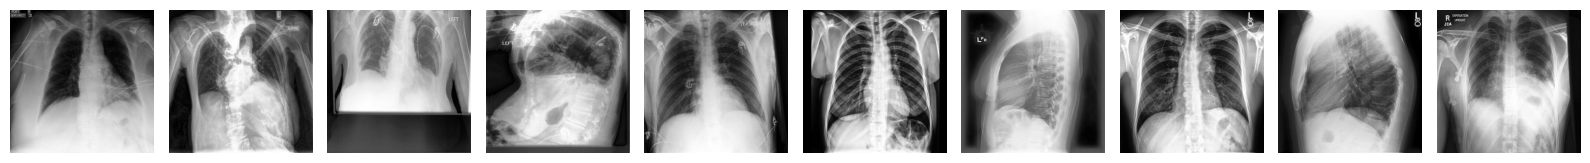

In [22]:
# Plot a sample of 10 original images
fig, axes = plt.subplots(1, 10, figsize=(16, 15))  # Adjust the figsize as needed
axes = axes.flatten()

for i, (image, label) in enumerate(train_ds.take(10)):
    ax = axes[i]
    ax.imshow(image.numpy())  # Select the first image from the batch
    ax.set_axis_off()

plt.tight_layout()
plt.show()

# Augementation

In [23]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(
        height_factor=(-0.05, -0.15),
        width_factor=(-0.05, -0.15)),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
])

In [24]:
def prepare(ds, shuffle=False, augment=False):
    if shuffle:
        ds = ds.shuffle(1000)

    ds = ds.batch(batch_size)
    ds = ds.cache()

    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)

    return ds.prefetch(buffer_size=AUTOTUNE)

In [25]:
train_ds = prepare(train_ds, shuffle=True, augment=augmentation_setting)
valid_ds = prepare(valid_ds)
test_ds = prepare(test_ds)

# Visualize Augmented Image

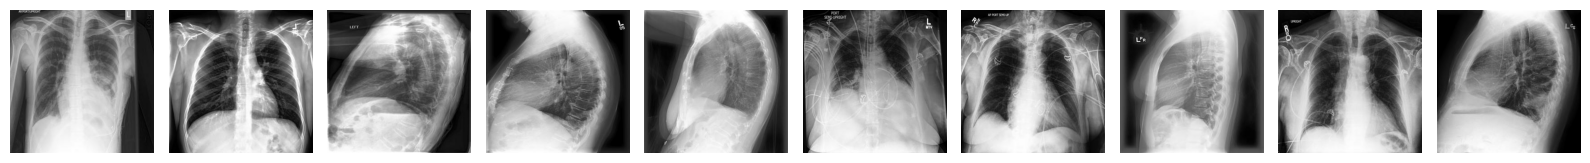

In [26]:
# Define a function to plot sample images
def plot_sample_images(dataset, num_samples=10):
    # Create an iterator for the dataset
    iterator = iter(dataset)

    # Get the next batch of images and labels
    sample_images, sample_labels = next(iterator)

    # Plot the sample images
    fig, axes = plt.subplots(1, num_samples, figsize=(16, 15))
    axes = axes.flatten()

    for i in range(num_samples):
        img = sample_images[i]
        ax = axes[i]
        ax.imshow(img.numpy())  # Convert TensorFlow tensor to NumPy array for plotting
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

# Visualize sample images from the training dataset
plot_sample_images(train_ds, num_samples=10)

# Functions

In [ ]:
def load_directories_and_dataframes(source_path):
    directories = {
        "train": os.path.join(source_path, 'CheXpert-v1.0/train'),
        "valid": os.path.join(source_path, 'CheXpert-v1.0/valid'),
        "test": os.path.join(source_path, 'CheXpert-v1.0/test')
    }

    dataframes = {
        "train": pd.read_csv(os.path.join(source_path, 'CheXpert-v1.0/train.csv')),
        "valid": pd.read_csv(os.path.join(source_path, 'CheXpert-v1.0/valid.csv')),
        "test": pd.read_csv(os.path.join(source_path, 'CheXpert-v1.0/test.csv'))
    }

    return directories, dataframes


In [ ]:
def get_tensors_from_paths(df_dict, source_path):
    tensor_dict = {}
    for key, df in df_dict.items():
        paths = [os.path.join(source_path, path) for path in df['Path']]
        tensor_dict[key] = tf.constant(paths)
    return tensor_dict

In [ ]:
def filter_and_prepare_labels(df_dict, columns):
    labels_dict = {}
    for key, df in df_dict.items():
        filtered_df = df[columns].replace(-1, 2).fillna(0)
        labels_dict[key] = np.array(filtered_df)
    return labels_dict

In [ ]:
def prepare_dataset(labels, all_pathology):
    # Transforming and separating labels
    trans_labels = np.zeros((labels.shape[0], len(all_pathology) * 3))
    for i in range(labels.shape[0]):
        for j in range(len(all_pathology)):
            index = int(j * 3 + labels[i, j])
            trans_labels[i, index] = 1

    separated_labels = [trans_labels[:, k*3:(k+1)*3].astype('float32') for k in range(len(all_pathology))]
    
    # Print the transformed label for the first image
    print("Transformed label for the first image:", [label[0] for label in separated_labels])

    return separated_labels

In [ ]:
def create_and_preprocess_datasets(image_tensors, labels_dict, preprocess_function, autotune):
    datasets = {}
    for key in image_tensors:
        ds = tf.data.Dataset.from_tensor_slices((image_tensors[key], labels_dict[key]))
        ds = ds.map(preprocess_function, num_parallel_calls=autotune)
        datasets[key] = ds
    return datasets

In [ ]:
# Define a custom preprocessing function
def preprocess_image(image_path, label):
    # Read the image file
    image = tf.io.read_file(image_path)
    # Decode the image from bytes to a tensor
    image = tf.image.decode_jpeg(image, channels=3)
    # Normalize pixel values to be in the range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [ ]:
directories, dataframes = load_directories_and_dataframes(source_path)
image_tensors = get_tensors_from_paths(dataframes, source_path)
labels_dict = filter_and_prepare_labels(dataframes, all_pathology)

train_labels = labels_dict['train']
valid_labels = labels_dict['valid']
test_labels = labels_dict['test']

train_labels_separated = prepare_dataset(train_labels, all_pathology)
valid_labels_separated = prepare_dataset(valid_labels, all_pathology)
test_labels_separated = prepare_dataset(test_labels, all_pathology)

# Define preprocess_image and AUTOTUNE
datasets = create_and_preprocess_datasets(image_tensors, {
    'train': tuple(train_labels_separated),
    'valid': tuple(valid_labels_separated),
    'test': tuple(test_labels_separated)
}, preprocess_image, AUTOTUNE)

train_ds = datasets['train']
valid_ds = datasets['valid']
test_ds = datasets['test']

In [ ]:
# import tensorflow_datasets as tfds
# from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(
        height_factor=(-0.05, -0.15),
        width_factor=(-0.05, -0.15)),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
])

In [ ]:
def prepare(ds, shuffle=False, augment=False):
    if shuffle:
        ds = ds.shuffle(5000)

    ds = ds.batch(batch_size)
    ds = ds.cache()

    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)

    return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
valid_ds = prepare(valid_ds)
test_ds = prepare(test_ds)

# Hyperparameter Tuning

In [27]:
# Redefining validation loss using only the negative and positive predictions

from keras import backend as K

def custom_loss(y_true, y_pred):
    # Compute the normalized version of y_pred
    y_pred_normalized = y_pred[:, :2] / K.sum(y_pred[:, :2], axis=-1, keepdims=True)
    
    # Add a third column with zeros
    y_pred_normalized_full = K.concatenate([y_pred_normalized, K.zeros_like(y_pred[:, 2:])], axis=-1)
    
    # Calculate the training loss
    training_loss = K.categorical_crossentropy(y_true, y_pred)
    
    # Calculate the validation loss using y_pred_normalized_full
    validation_loss = K.categorical_crossentropy(y_true, y_pred_normalized_full)
    
    # Use K.in_train_phase to return the appropriate loss based on the training phase
    return K.in_train_phase(training_loss, validation_loss)

In [ ]:
# def create_model(hp, image_size=320, load_previous_weights=False, freeze_cnn=False):
#     with mirrored_strategy.scope():
#         base_model = DenseNet121(include_top=False, input_shape=(image_size, image_size, 3), weights='imagenet')

#         # Add a global spatial average pooling layer
#         x = base_model.output
#         x = GlobalAveragePooling2D()(x)

#         # First dense layer with tunable units and dropout
#         dense_1_units = hp.Int('dense_1_units', min_value=512, max_value=3072, step=512)
#         x = Dense(dense_1_units, activation='relu')(x)
#         x = BatchNormalization()(x)
#         dropout_1 = hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)
#         x = Dropout(dropout_1)(x)

#         # Second dense layer with tunable units and dropout
#         dense_2_units = hp.Int('dense_2_units', min_value=256, max_value=1536, step=256)
#         x = Dense(dense_2_units, activation='relu')(x)
#         x = BatchNormalization()(x)
#         dropout_2 = hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)
#         x = Dropout(dropout_2)(x)

#         # Define multiple outputs
#         Pathology1 = Dense(units=3, activation='softmax', name='pathology1')(x)
#         Pathology2 = Dense(units=3, activation='softmax', name='pathology2')(x)
#         Pathology3 = Dense(units=3, activation='softmax', name='pathology3')(x)
#         Pathology4 = Dense(units=3, activation='softmax', name='pathology4')(x)
#         Pathology5 = Dense(units=3, activation='softmax', name='pathology5')(x)

#         # Create the model
#         model = Model(inputs=base_model.input, outputs=[Pathology1, Pathology2, Pathology3, Pathology4, Pathology5])

#         # Recover previously trained weights
#         if load_previous_weights:
#             try:
#                 model.load_weights(f'./logs/fit/{approach}/run_{run+1}/final_model.h5')
#                 print('Weights successfully loaded')
#             except:
#                 print('Weights not loaded')

#         # Freeze CNN layers if specified
#         if freeze_cnn:
#             for layer in base_model.layers:
#                 layer.trainable = False

#         # Tunable learning rate
#         learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')

#         # Compile the model
#         model.compile(
#             optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999),
#             loss=custom_loss,
#             metrics=['accuracy', AUC()])

#     return model


In [28]:
def create_model(hp, image_size=320, load_previous_weights=False, freeze_cnn=False):
    with mirrored_strategy.scope():
        base_model = DenseNet121(include_top=False, input_shape=(image_size, image_size, 3), weights='imagenet')

        # Add a global spatial average pooling layer
        x = base_model.output
        x = GlobalAveragePooling2D()(x)

        # First dense layer with tunable units and dropout
        dense_1_units = hp.Int('dense_1_units', min_value=512, max_value=3072, step=512)
        x = Dense(dense_1_units, activation='relu')(x)
        x = BatchNormalization()(x)
        dropout_1 = hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)
        x = Dropout(dropout_1)(x)

        # Second dense layer with tunable units and dropout
        dense_2_units = hp.Int('dense_2_units', min_value=256, max_value=1536, step=256)
        x = Dense(dense_2_units, activation='relu')(x)
        x = BatchNormalization()(x)
        dropout_2 = hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)
        x = Dropout(dropout_2)(x)

        # Dense layers
        for i in range(len(all_pathology)):
            globals()[f'Pathology{i}'] = Dense(units=3, activation='softmax', name=f'pathology{i}')(x)

        # Gather the outputs in a list for the model
        model_outputs = [globals()[f'Pathology{k}'] for k in range(len(all_pathology))]

        # Create the model with these outputs
        model = Model(inputs=base_model.input, outputs=model_outputs)
        
        # Recover previously trained weights
        if load_previous_weights:
            try:
                model.load_weights(f'./logs/fit/{approach}/run_{run+1}/final_model.h5')
                print('Weights successfully loaded')
            except:
                print('Weights not loaded')

        # Freeze CNN layers if specified
        if freeze_cnn:
            for layer in base_model.layers:
                layer.trainable = False

        # Tunable learning rate
        learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')

        # Compile the model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999),
            loss=custom_loss,
            metrics=['accuracy', AUC()])

    return model


In [29]:
tuner = kt.Hyperband(
    create_model,
    objective=Objective('val_auc', direction ="max"),
    max_epochs=4,
    factor=5,
    hyperband_iterations=1,  # number of times to iterate over the hyperband algorithm
    directory='kt_hyperband',
    project_name=f'{approach}_tuning'
)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [30]:
# Create a callback to stop training early after reaching a certain value for the validation loss.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [31]:
# Start the hyperparameter tuning process
tuner.search(train_ds, epochs=4, validation_data=(valid_ds), callbacks=[stop_early], verbose = 2)

Trial 2 Complete [00h 37m 58s]

Best val_auc So Far: None
Total elapsed time: 01h 27m 15s


In [32]:
best_hps = tuner.get_best_hyperparameters()[0]

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. Here are the optimal values:
Dense1_units: {best_hps.get('dense_1_units')}
Dense2_units: {best_hps.get('dense_2_units')}
Dropout1: {best_hps.get('dropout_1')}
Dropout2: {best_hps.get('dropout_2')}
Learning rate: {best_hps.get('learning_rate')}
""")


The hyperparameter search is complete. Here are the optimal values:
Dense1_units: 512
Dense2_units: 1280
Dropout1: 0.30000000000000004
Dropout2: 0.1
Learning rate: 0.0006831971958959775



In [ ]:
# # Build the model with the optimal hyperparameters and train it on the data for 50 epochs
# # Find the optimal number of epochs to train the model with the hyperparameters obtained from the search.
# cnn = tuner.hypermodel.build(best_hps)
# history = cnn.fit(train_ds, epochs=10, validation_data=(valid_ds), verbose = 2)

In [ ]:
# num_pathologies = len(all_pathology)  # Assuming all_pathology is a list containing all pathologies

# # Extract AUC values for each pathology using a loop
# auc_values = []
# for i in range(num_pathologies):
#     auc_key = f'val_pathology{i}_auc_1'
#     if auc_key in history.history:
#         auc_values.append(history.history[auc_key])
#     else:
#         print(f"AUC for pathology {i} not found in history.")

# # Calculate the average AUC per epoch
# if auc_values:
#     average_auc_per_epoch = np.mean(auc_values, axis=0)

#     # Find the best epoch
#     best_epoch = np.argmax(average_auc_per_epoch) + 1
#     print('Best epoch based on average AUC: %d' % best_epoch)
# else:
#     print("No AUC values were found.")


# Train the Model

In [33]:
import time

def create_callbacks(run_num):
    log_dir = f"logs/fit/{approach}/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    # Modify the checkpoint_dir to include the run number.
    checkpoint_dir = f"logs/fit/{approach}/run_{run_num}"

    # Ensure the directory exists
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    # SaveCheckpointCallback class definition
    class SaveCheckpointCallback(tf.keras.callbacks.Callback):
        def __init__(self, checkpoint_dir, save_interval):
            super(SaveCheckpointCallback, self).__init__()
            self.checkpoint_dir = checkpoint_dir
            self.save_interval = save_interval
            self.iteration = 0

        def on_batch_end(self, batch, logs=None):
            self.iteration += 1
            if self.iteration % self.save_interval == 0:
                model_checkpoint = os.path.join(self.checkpoint_dir, f"model_checkpoint_{self.iteration}.h5")
                self.model.save(model_checkpoint)
                print(f"Saved checkpoint at iteration {self.iteration} to {model_checkpoint}")

    save_interval = int(iterations/num_gpus) 
    checkpoint_callback = SaveCheckpointCallback(checkpoint_dir, save_interval)
    
    return [checkpoint_callback, tensorboard_callback]

In [34]:
trained_models = []

def train(num_runs, train_ds, valid_ds, best_epoch):

    for run in range(num_runs):
        print(f"Run {run + 1} of {num_runs}")

        # Clear previous session to ensure a fresh start for each run
        tf.keras.backend.clear_session()
        
        model = tuner.hypermodel.build(best_hps)
        callbacks = create_callbacks(run+1)

        start = time.time()
        history = model.fit(train_ds, epochs=best_epoch, validation_data=valid_ds, batch_size=batch_size, callbacks=callbacks, verbose=2)
        print("Total time for run", run + 1, ": ", time.time() - start, "seconds")
        
        # Save final model
        final_model_path = f"logs/fit/{approach}/run_{run+1}/final_model.h5"
        model.save(final_model_path)
        print(f"Final model saved for run {run+1} at {final_model_path}")
        
        trained_models.append(model)

    return trained_models

# Define the number of runs
num_runs = 3
training = train(num_runs, train_ds, valid_ds, 4)

Run 1 of 3
Epoch 1/4
INFO:tensorflow:Collective all_reduce tensors: 398 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 398 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved checkpoint at iteration 1200 to logs/fit/umulti_ht_noaug/run_1/model_checkpoint_1200.h5
Saved checkpoint at iteration 2400 to logs/fit/umulti_ht_noaug/run_1/model_checkpoint_2400.h5
3491/3491 - 960s - loss: 14.7007 - pathology0_loss: 2.8407 - pathology1_loss: 0.9184 - pathology2_loss: 2.2506 - pathology3_loss: 1.3891 - pathology4_loss: 1.3410 - pathology5_loss: 0.2912 - pathology6_loss: 1.1100 - pathology7_loss: 1.0602 - pathology8_loss: 0.2961 - pathology9_loss: 1.4944 - pathology10_loss: 0.5158 - pathology11_loss: 0.2889 - pathology12_loss: 0.2370 - pathology13_loss: 0.6673 - pathology0_accuracy: 0.5207 - pathology0_auc: 0.6949 - pathology1_accuracy: 0.7395 - pathology1_auc: 0.8640 - pathology2_accuracy: 0.7109 - pathology2_auc: 0.8555 - pathology3_accuracy: 0.5943 - pathology3_auc: 0.7765 - pathology4_accuracy: 0.4280 - pathology4_auc: 0.6387 - pathology5_accuracy: 0.6325 - pathology5_auc: 0.7635 - pathology6_accuracy: 0.8665 - pathology6_auc: 0.9185 - pathology7_accuracy: 0.3

In [ ]:
%tensorboard --logdir logs --port 8896

# Model Evaluate at Iteration

In [35]:
# Initialize a list to store checkpoint paths for each run
checkpoint_paths_list = []

for run in range(num_runs):
    checkpoint_paths = []  # Store checkpoint paths for the current model

    # Collect checkpoint paths
    for iteration in range(checkpoint_start, 13201, checkpoint_start):  # Modify this range according to your save_interval and number of checkpoints
        checkpoint_path = f"logs/fit/{approach}/run_{run + 1}/model_checkpoint_{iteration}.h5"
        checkpoint_paths.append(checkpoint_path)

    checkpoint_paths_list.append(checkpoint_paths)


In [36]:
all_valid_images = []
all_valid_labels = []

for images, (labels1, labels2, labels3, labels4, labels5) in valid_ds:
    all_valid_images.append(images.numpy())
    all_valid_labels.append(np.stack([labels1.numpy(), labels2.numpy(), labels3.numpy(), labels4.numpy(), labels5.numpy()], axis=1))

# Concatenate all images and labels into two large numpy arrays
all_valid_images = np.concatenate(all_valid_images, axis=0)
all_valid_labels = np.concatenate(all_valid_labels, axis=0)
print(f"all_valid_images shape: {all_valid_images.shape}")
print(f"all_valid_labels shape: {all_valid_labels.shape}")

ValueError: too many values to unpack (expected 5)

In [39]:
# Prepare to store images and labels
all_valid_images = []
all_valid_labels = []

# Unpack images and labels dynamically
for images, labels in valid_ds:
    all_valid_images.append(images.numpy())

    # Dynamically unpack the labels and stack them along a new axis
    labels_np = [label.numpy() for label in labels]
    all_valid_labels.append(np.stack(labels_np, axis=1))  # Stacking along a new axis

# Concatenate all images and labels into two large numpy arrays
all_valid_images = np.concatenate(all_valid_images, axis=0)
all_valid_labels = np.concatenate(all_valid_labels, axis=0)

print(f"all_valid_images shape: {all_valid_images.shape}")
print(f"all_valid_labels shape: {all_valid_labels.shape}")

all_valid_images shape: (234, 320, 320, 3)
all_valid_labels shape: (234, 14, 3)


In [ ]:
print(all_valid_labels[0])

In [40]:
# Initialize a list to store predictions for each checkpoint
all_predictions = []

# Iterate through the collected checkpoint paths and corresponding trained model
for model, checkpoint_paths in zip(trained_models, checkpoint_paths_list):
    predictions = []  # Store predictions for the current run

    # Load each checkpoint and predict on the validation set
    for checkpoint_path in checkpoint_paths:
        model.load_weights(checkpoint_path)

        # Predict on the validation set
        checkpoint_predictions = model.predict(all_valid_images)
        predictions.append(checkpoint_predictions)

    all_predictions.append(predictions)
all_predictions = np.array(all_predictions)

print(f"all pred shape: {all_predictions.shape}")


8/8 [==============================] - 1s 32ms/step
all pred shape: (3, 11, 14, 234, 3)


In [41]:
print(all_predictions[0][0][0][0])

[0.767352   0.03990966 0.19273841]


In [42]:
from sklearn.metrics import roc_auc_score
from scipy.special import softmax

num_pathologies = 5
iteration_auroc = []  # List of all AUROCs per pathology per iteration

for run_predictions in all_predictions:
    for checkpoint_predictions in run_predictions:
        checkpoint_auroc_scores = []  # Store AUROC scores for the current model

        for pathology_index in range(num_pathologies):
            true_labels = all_valid_labels[:, pathology_index, 1]  # True labels for the positive class

            # Extract the probabilities for negative and positive classes for all images
            neg_pos_probs = checkpoint_predictions[pathology_index, :, :2]  # Probabilities for negative and positive classes for each image

            # Apply softmax to these two probabilities for each image
            softmax_probs = softmax(neg_pos_probs, axis=1)
            positive_probs = softmax_probs[:, 1]  # Probability of the positive class for each image
            
            # Compute AUROC
            auroc = roc_auc_score(true_labels, positive_probs)
            checkpoint_auroc_scores.append(auroc)

        iteration_auroc.append(checkpoint_auroc_scores)

# Convert iteration_auroc to array
iteration_auroc = np.array(iteration_auroc)

print(f"iteration_auroc_shape: {iteration_auroc.shape}")

iteration_auroc_shape: (33, 5)


In [43]:
# Calculate the average AUROC across 5 pathologies
average_auroc = np.mean(iteration_auroc, axis = 1)

# Calculate the indices that would sort the average AUROC list in descending order
sorted_indices = np.argsort(average_auroc)[::-1]

# Get the top top_rank indices
top_indices = sorted_indices[:top_rank]

# Initialize a list to store the corresponding checkpoint_auroc_scores
best_checkpoint_auroc_scores = []

# Extract the checkpoint_auroc_scores for top_rank
for index in top_indices:
    best_checkpoint_auroc_scores.append(iteration_auroc[index])

best_checkpoint_auroc_scores = np.array(best_checkpoint_auroc_scores)

# Compute AUROC, Standard Deviation, and Confidence Intervals
auroc_pathology = np.mean(best_checkpoint_auroc_scores, axis=0)
std_dev_pathology = np.std(best_checkpoint_auroc_scores, axis=0)
confidence_intervals = [(auroc - 1.96 * std, auroc + 1.96 * std) for auroc, std in zip(auroc_pathology, std_dev_pathology)]

# Header
print(f"{'Pathology':<15} {'Average AUROC':<15} {'Standard Error':<17} {'95% Confidence Interval'}")

# Separator
print('-' * 65)

# Table content
for i, pathology in enumerate(competition_pathology):
    standard_error = std_dev_pathology[i] / np.sqrt(len(best_checkpoint_auroc_scores))
    lower_bound, upper_bound = confidence_intervals[i]
    print(f"{pathology:<15} {auroc_pathology[i]:<15.4f} {standard_error:<17.4f} ({lower_bound:.4f}, {upper_bound:.4f})")

# Overall AUROC
overall_ave = np.mean(average_auroc[top_indices])
print(f"\nOverall average AUROC (from top {top_rank} models/checkpoints): {overall_ave:.4f}")

Pathology       Average AUROC   Standard Error    95% Confidence Interval
-----------------------------------------------------------------
Atelectasis     0.7298          0.0406            (0.3742, 1.0853)
Cardiomegaly    0.7428          0.0174            (0.5906, 0.8949)
Consolidation   0.7694          0.0283            (0.5213, 1.0174)
Edema           0.8407          0.0083            (0.7682, 0.9131)
Pleural Effusion 0.8933          0.0049            (0.8504, 0.9362)

Overall average AUROC (from top 20 models/checkpoints): 0.7952


# Performance on Test

In [44]:
# Prepare to store images and labels
all_test_images = []
all_test_labels = []

# Unpack images and labels dynamically
for images, labels in test_ds:
    all_test_images.append(images.numpy())

    # Dynamically unpack the labels and stack them along a new axis
    labels_np = [label.numpy() for label in labels]
    all_test_labels.append(np.stack(labels_np, axis=1))  # Stacking along a new axis

# Concatenate all images and labels into two large numpy arrays
all_test_images = np.concatenate(all_test_images, axis=0)
all_test_labels = np.concatenate(all_test_labels, axis=0)

print(f"all_test_images shape: {all_test_images.shape}")
print(f"all_test_labels shape: {all_test_labels.shape}")

all_test_images shape: (668, 320, 320, 3)
all_test_labels shape: (668, 14, 3)


In [ ]:
# all_test_images = []
# all_test_labels = []

# for images, (labels1, labels2, labels3, labels4, labels5) in test_ds:
#     all_test_images.append(images.numpy())
#     all_test_labels.append(np.stack([labels1.numpy(), labels2.numpy(), labels3.numpy(), labels4.numpy(), labels5.numpy()], axis=1))

# # Concatenate all images and labels into two large numpy arrays
# all_test_images = np.concatenate(all_test_images, axis=0)
# all_test_labels = np.concatenate(all_test_labels, axis=0)
# print(f"all_test_images shape: {all_test_images.shape}")
# print(f"all_test_labels shape: {all_test_labels.shape}")

In [45]:
# Calculate the number of checkpoints per model
num_checkpoints_per_model = len(checkpoint_paths_list[0])  # or use all_predictions.shape[1] if available

# Determine the best model and checkpoint indices based on the best_model_index
best_model_index = top_indices[0] // num_checkpoints_per_model
best_checkpoint_index = top_indices[0] % num_checkpoints_per_model

# Reference the predictions of the best model and checkpoint
best_model_predictions = all_predictions[best_model_index, best_checkpoint_index]

# Load the best checkpoint weights into the corresponding model
best_model = trained_models[best_model_index]
best_checkpoint_path = checkpoint_paths_list[best_model_index][best_checkpoint_index]
best_model.load_weights(best_checkpoint_path)

In [46]:
# Predict on the test set using the best model
test_predictions_list = best_model.predict(all_test_images)

# Assuming test_predictions_list is a list of arrays, where each array has shape (num_samples, num_classes)
# You need to stack these arrays along a new axis to get a combined array
test_predictions = np.stack(test_predictions_list, axis=1)  # This will create an array of shape (num_samples, num_pathologies, num_classes)

print(f"test_predictions shape: {test_predictions.shape}")


21/21 [==============================] - 2s 62ms/step
test_predictions shape: (668, 14, 3)


In [47]:
# Assuming positive class is the last in the predictions
positive_class_index = 1

# Directory where the figures will be saved
save_dir = f"test_performance/{approach}"
os.makedirs(save_dir, exist_ok=True)

# 2. Calculate and Plot ROC for each pathology
for i in range(num_pathologies):
    true_labels = all_test_labels[:, i, positive_class_index]
    positive_probs = test_predictions[:, i, positive_class_index]
    fpr, tpr, _ = roc_curve(true_labels, positive_probs)
    auc = roc_auc_score(true_labels, positive_probs)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{competition_pathology[i]} (AUC = {auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {competition_pathology[i]}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    
    # Save ROC curve
    roc_filename = f"{competition_pathology[i]}_auroc.png"
    plt.savefig(os.path.join(save_dir, roc_filename))
    plt.close()

# 3. Calculate and Plot PR curve for each pathology
for i in range(num_pathologies):
    true_labels = all_test_labels[:, i, positive_class_index]
    positive_probs = test_predictions[:, i, positive_class_index]
    precision, recall, _ = precision_recall_curve(true_labels, positive_probs)
    average_precision = average_precision_score(true_labels, positive_probs)
    plt.figure()
    plt.plot(recall, precision, label=f"{competition_pathology[i]} (AP = {average_precision:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve for {competition_pathology[i]}")
    plt.legend(loc="upper right")
    plt.tight_layout()

    # Save PR curve
    pr_filename = f"{competition_pathology[i]}_pr.png"
    plt.savefig(os.path.join(save_dir, pr_filename))
    plt.close()

# Explaining Predictions

In [65]:
def find_image_with_top_prediction_pathname(all_test_images, all_test_labels, all_pathology, best_model, pathname):
    for index, image in enumerate(all_test_images):
        # Get the top 5 predictions for the current image
        predictions = best_model.predict(np.array([image]), verbose=0)[0]
        probabilities_and_pathologies = [(p, all_pathology[i]) for i, p in enumerate(predictions)]
        top_5_predictions = sorted(probabilities_and_pathologies, key=lambda x: x[0], reverse=True)[:5]

        # Check if the top prediction is pathname
        if top_5_predictions[0][1] == pathname:
            print(f"Found an image with {pathname} as the top prediction at index: {index}\n")

            # Display the image
            plt.figure(figsize=(5,5))
            plt.imshow(image, cmap='gray')
            plt.title(f"Image {index}")
            plt.axis('off')  # Hide the axis
            plt.show()

            # Print true labels
            true_labels(index, all_test_labels, all_pathology)
            print("\nTop 5 Predictions:")
            for probability, pathology in top_5_predictions:
                print("{:<25} {:.2f}".format(pathology, probability))
    
pathname = "Consolidation"
find_image_with_top_prediction_pathname(all_test_images, all_test_labels, all_pathology, best_model, pathname)


## LIME

(320, 320, 3)


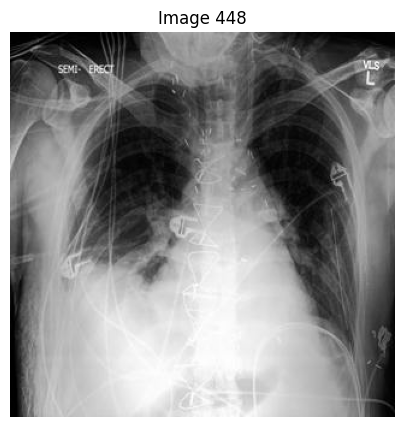

In [72]:
import random

image_index = random.randint(0,all_test_images.shape[0])
image = all_test_images[image_index]
print(image.shape)

plt.figure(figsize=(5,5))
plt.imshow(image, cmap='gray')
plt.title(f"Image {image_index}")
plt.axis('off')  # Hide the axis
plt.show()

In [83]:
def model_predict(images):
    predictions_list = best_model.predict(images, verbose=0)
    # Stack the predictions for all pathologies
    predictions = np.stack(predictions_list, axis=1)
    return predictions

# Get the prediction for an individual image (assuming image is preprocessed accordingly)
predictions = model_predict(np.array([image]))[0]

print(predictions.shape)

# Initialize a list to store top predictions for each pathology
top_predictions = []

for i, pathology_predictions in enumerate(predictions):
    # Extract the probabilities for negative and positive classes
    neg_pos_probs = pathology_predictions[:2]
    # Apply softmax
    softmax_probs = softmax(neg_pos_probs)
    # Get the probability of the positive class
    positive_prob = softmax_probs[1]
    # Append to the list
    top_predictions.append((positive_prob, all_pathology[i]))

# Sort the top predictions
top_predictions.sort(key=lambda x: x[0], reverse=True)

# Print the top predictions
print("Top Predictions:")
print("{:<25} {}".format("Pathology", "Probability"))
for probability, pathology in top_predictions:
    print("{:<25} {:.2f}".format(pathology, probability))
    
print("")
    
# Retrieve and print the corresponding label
label_for_image = all_test_labels[image_index]

# Print only the pathologies where the state is "Present"
print(f"Pathologies present for image index {image_index}:")
for i, pathology_state in enumerate(label_for_image):
    if np.argmax(pathology_state) == 1:  # Check if "Present" state has the highest value
        print(all_pathology[i])  # Print the name of the pathology

(14, 3)
Top Predictions:
Pathology                 Probability
Support Devices           0.66
Lung Opacity              0.58
Edema                     0.53
Pleural Effusion          0.53
Atelectasis               0.46
Cardiomegaly              0.43
Consolidation             0.37
Fracture                  0.32
Pneumothorax              0.32
Enlarged Cardiomediastinum 0.31
Pneumonia                 0.31
Lung Lesion               0.30
Pleural Other             0.28
No Finding                0.28

Pathologies present for image index 448:
Atelectasis
Consolidation
Pleural Effusion
Enlarged Cardiomediastinum
Lung Opacity
Support Devices


In [ ]:
print(image.shape)

100%|██████████| 1000/1000 [00:40<00:00, 24.73it/s]


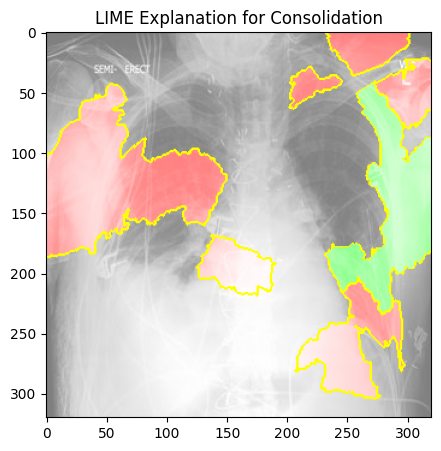

In [98]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np

pathology_interest = 2 #0: Atelectasis 1: Cardiomegaly 2: Consolidation 3: Edema 4: Pleural Effusion

# Function to predict only specific pathology of interest
def model_predict_for_pathology(images):
    predictions_list = best_model.predict(images, verbose=0)
    predictions = np.stack(predictions_list, axis=1)
    pathology_predictions = predictions[:, pathology_interest, 1] # Extract positive class
    return pathology_predictions.reshape(-1, 1)

# Instantiate the LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Explain instance with LIME
explanation = explainer.explain_instance(
    image,  
    model_predict_for_pathology,
    top_labels=1, 
    hide_color=0,
    num_samples=1000 
)

# Get the explanation for Cardiomegaly
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    num_features=10,
    hide_rest=False
)

# Visualize the explanation
plt.figure(figsize=(5, 5))
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))  
plt.title(f"LIME Explanation for {all_pathology[pathology_interest]}")
plt.savefig(f'lime/{approach}_{image_index}_{all_pathology[pathology_interest]}.png')
plt.show()


## Grad CAM

In [84]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore
from matplotlib.cm import jet
from tf_keras_vis.utils import normalize
from matplotlib.colors import Normalize

In [85]:
last_conv_layer_name = 'conv5_block16_concat' 

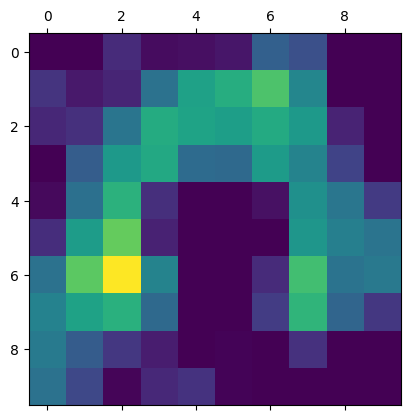

In [86]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pathology_index):
    # Model that maps the input image to the activations of the last conv layer as well as the output layer
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.outputs[pathology_index]]
    )

    # Compute the gradient of the class output neuron for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        class_channel = preds[:, 1]  # Assuming '1' corresponds to the positive class for the pathology

    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by 'how important this channel is' with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purposes, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Prepare image
# Assuming 'image' is your input image
img_array = np.array([image])

# Generate heatmap
heatmap = make_gradcam_heatmap(img_array, best_model, last_conv_layer_name, pathology_interest)

# Display heatmap
plt.matshow(heatmap)
plt.show()


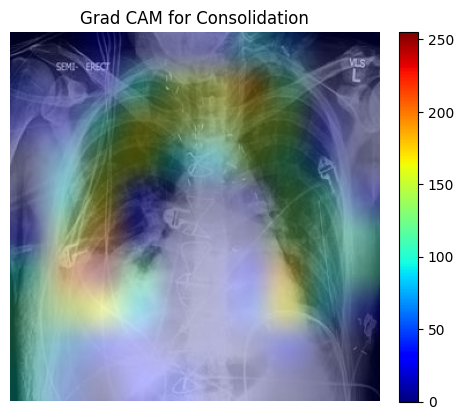

In [97]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow.keras.utils as keras_utils
import matplotlib.cm as cm

def display_gradcam(img, heatmap, image_index, cam_path=f"{approach}", alpha=0.4):
    cam_path = f"cam/{approach}_{image_index}.jpg"

    # Check if the directory exists, and if not, create it
    cam_dir = os.path.dirname(cam_path)
    if not os.path.exists(cam_dir):
        os.makedirs(cam_dir)
    
    # Ensure the original image is in the correct format
    img = np.uint8(img * 255) if np.max(img) <= 1 else np.uint8(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matplotlib.colormaps['jet']

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras_utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras_utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras_utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM with a colorbar
    fig, ax = plt.subplots()
    im = ax.imshow(superimposed_img)
    ax.axis('off')  # Turn off axis

    # Create a ScalarMappable with the colormap used for the heatmap
    norm = Normalize(vmin=0, vmax=255)
    sm = cm.ScalarMappable(cmap=jet, norm=norm)
    sm.set_array([])  # Set the array to an empty list

    # Add the colorbar to the figure
    plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    
    # Get the pathology name using the top prediction index
    pathology_name = all_pathology[pathology_interest]
    plt.title(f"Grad CAM for {pathology_name}")

    plt.show()

# Assuming 'image' and 'heatmap' are already defined
display_gradcam(image, heatmap, image_index)

# Saliency Map

In [90]:
from tf_keras_vis.saliency import Saliency

In [91]:
# Predict using the model
predictions = best_model.predict(np.array([image]))

# Print the structure and shape of the model outputs
for i, pred in enumerate(predictions):
    print(f"Output {i}: shape = {pred.shape}")

1/1 [==============================] - 0s 246ms/step
Output 0: shape = (1, 3)
Output 1: shape = (1, 3)
Output 2: shape = (1, 3)
Output 3: shape = (1, 3)
Output 4: shape = (1, 3)
Output 5: shape = (1, 3)
Output 6: shape = (1, 3)
Output 7: shape = (1, 3)
Output 8: shape = (1, 3)
Output 9: shape = (1, 3)
Output 10: shape = (1, 3)
Output 11: shape = (1, 3)
Output 12: shape = (1, 3)
Output 13: shape = (1, 3)


In [92]:
for i, output in enumerate(best_model.outputs):
    print(f"Output {i}: {output}")

Output 0: KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='pathology0/Softmax:0', description="created by layer 'pathology0'")
Output 1: KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='pathology1/Softmax:0', description="created by layer 'pathology1'")
Output 2: KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='pathology2/Softmax:0', description="created by layer 'pathology2'")
Output 3: KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='pathology3/Softmax:0', description="created by layer 'pathology3'")
Output 4: KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='pathology4/Softmax:0', description="created by layer 'pathology4'")
Output 5: KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='pathology5/Softmax:0', description="created by layer 'pathology5'")
Output 6: KerasT

Shape of saliency_maps: (1, 320, 320)


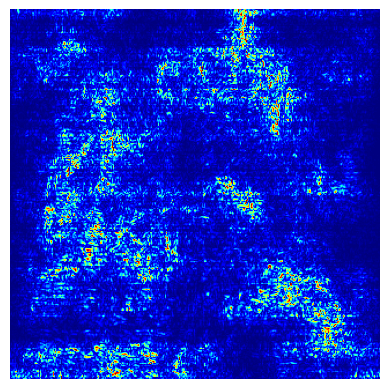

In [94]:
# Create a list of dummy score functions for each output
scores = [(lambda x: x[0, 0]) for _ in range(len(best_model.outputs))]

# Replace the score function for the pathology of interest
def pathology_score(output):
    return output[:, 1]  # Target the positive class probability for the pathology

# Update the score function for the pathology of interest in the list
scores[pathology_interest] = pathology_score

# Create Saliency object
saliency = Saliency(best_model, clone=False)

# Generate saliency maps for all outputs
saliency_maps = saliency(scores, np.array([image]))

# Confirm the shape and normalize the saliency map
print("Shape of saliency_maps:", saliency_maps.shape)
saliency_map_for_pathology = normalize(saliency_maps[0])  # Assuming one map

# Display the saliency map
plt.imshow(saliency_map_for_pathology, cmap='jet')
plt.axis('off')
plt.savefig(f'saliency/{image_index}_{approach}_{all_pathology[pathology_interest]}.png')
plt.show()

## Smooth Grad

In [95]:
from matplotlib.cm import ScalarMappable

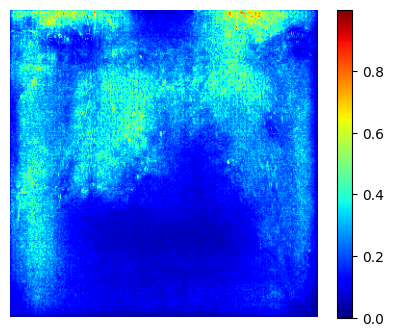

In [96]:
saliency_map = saliency(scores, np.array([image]), smooth_samples=100)
saliency_map = normalize(saliency_map)

# Remove the batch dimension and display the saliency map
saliency_map = saliency_map[0]

fig, ax = plt.subplots(figsize=(6, 4))

# Display the saliency map
img_display = ax.imshow(saliency_map, cmap='jet')
ax.axis('off')  # Turn off axis

# Create a colorbar
norm = Normalize(vmin=saliency_map.min(), vmax=saliency_map.max())
sm = ScalarMappable(cmap='jet', norm=norm)
sm.set_array([])  # Set the array to an empty list

# Add the colorbar to the figure
fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
plt.savefig(f'smoothgrad/{image_index}_{approach}_{all_pathology[pathology_interest]}.png')
plt.show()